In [1]:
import scipy
import numpy as np
from numpy import random

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from matplotlib import cm

import sys

import pickle

import pprint

import import_ipynb

import Stiefel_Exp_Log                as StEL
import Stiefel_Aux        as StAux

importing Jupyter notebook from Stiefel_Exp_Log.ipynb
importing Jupyter notebook from Stiefel_Aux.ipynb
(200, 90)


In [2]:
def random_Tangent_maxCruv(U0):
    n = np.shape(U0)[0]
    p = np.shape(U0)[1]
    
    #orthogonal completion
    Q, R = np.linalg.qr(U0,mode='complete')
    U0perp = Q[:,p:n]
    
    #matrices spanning the tangent space plane of maximal sectional curvature (up to transformations)
    B1 = 1/np.sqrt(2)*np.array([[0,1],[1,0]])
    B2 = 1/np.sqrt(2)*np.array([[1,0],[0,-1]])
    B1 = np.concatenate((B1,np.zeros((2,p-2))),axis=1)
    B2 = np.concatenate((B2,np.zeros((2,p-2))),axis=1)
    B1 = np.concatenate((B1,np.zeros((n-p-2,p))),axis=0)
    B2 = np.concatenate((B2,np.zeros((n-p-2,p))),axis=0)
        
    #orthogonal transformation
    trfo1 = random.randint(0,2)
    
    if trfo1:
        T1,R = np.linalg.qr(random.rand(n-p,n-p),mode='complete')
        B1 = np.dot(T1,B1)
        B2 = np.dot(T1,B2)
        trfo2 = random.randint(0,2)
        if trfo2:
            T1,R = np.linalg.qr(random.rand(p,p),mode='complete')
            B1 = np.dot(B1,T1)
            B2 = np.dot(B2,T1)
    else:
        T1,R = np.linalg.qr(random.rand(p,p),mode='complete')
        B1 = np.dot(B1,T1)
        B2 = np.dot(B2,T1)
        
    #sectional curvature 
    #print(1/2*np.linalg.norm(np.dot(B2,B1.transpose())-np.dot(B1,B2.transpose()),'fro')**2 + 1/8*np.linalg.norm(np.dot(B2.transpose(),B1)-np.dot(B1.transpose(),B2),'fro')**2)
    
    #Tangent in Plane of B1,B2 of norm 1
    a = random.uniform(0,1)
    B = a*B1+np.sqrt(1-a**2)*B2
    
    Delta = np.dot(U0perp,B)
    return Delta
#end fct

In [55]:
def Test_Rank_Log(n,p,mu_list,runs):
    # calculate reached cut points for different starting points U0 in St(n,p).
    #
    # Input:
    # n,p: dimensions of St(n,p).
    # mu_list: list of different length of tangent vectors defining the examined geodesics.
    # runs: number of different starting points U0.
    #
    # Output:
    # rank_to_mu: Sparse matrix saving the number of reached cut points for the rank of each tangent vector defining the
    #             examined geodesic.

    fail_mu = np.zeros(mu_list.shape)
    
    tau = 1.0e-12
    
    for r in range(runs):
        #create random starting point U0
        X =  random.rand(n,p)
        U0, R = scipy.linalg.qr(X, overwrite_a=True,\
                                        lwork=None,\
                                        mode='economic',\
                                        pivoting=False,\
                                        check_finite=True)
        
        #create random Tangent vector from plane with max sectional curvature
        Delta0 = random_Tangent_maxCruv(U0)
        
        notinj = 1
        for i in range(len(mu_list)):
            if notinj:
                Delta = mu_list[i]*Delta0
                U = StEL.Stiefel_Exp(U0,Delta)
                #Try to compute Stiefel_Log 
                Deltanew, conv = StEL.Stiefel_Log(U0,U,tau)
       
                if (np.linalg.norm(Delta-Deltanew) > 1.0e-5) and (mu_list[i] >= np.lib.scimath.sqrt(StAux.alphaMetric(Deltanew, Deltanew, U0,0.0))) and (np.linalg.norm(U-StEL.Stiefel_Exp(U0,Deltanew)) < 1.0e-5):#+1.0e-6):
                    #Delta is not equal to Deltanew and ||Deltanew|| < mu = ||Delta||. 
                    #Therefore, a shorter geodesic was found and the cut point of the examined geodesic was already reached
                    print('i: ',i)
                    print(mu_list[i])
                    if i <=9:
                        print(np.linalg.norm(Delta-Deltanew))
                        print(np.lib.scimath.sqrt(StAux.alphaMetric(Deltanew, Deltanew, U0,0.0)))
                        print(np.linalg.norm(U-StEL.Stiefel_Exp(U0,Deltanew)))
                    notinj = 0
                    #save 'cut point'
                    fail_mu[i] += 1
                        
                    for j in range(i+1,len(mu_list)):
                        fail_mu[j] += 1
                    #end for k
                        

    #end for j
    return fail_mu
#end fct

In [2]:
def add_elOverMu(Dict,const_rel):
    # Add reached cut points for each distance mu.
    
    failed_mu = np.zeros(Dict[list(Dict.keys())[0]].shape)
    
    for key in Dict.keys():
        A = Dict[key]
        entries = A.nonzero()
        for i in entries:
            failed_mu[i] += A[i]
        #end for i
    #end for key
    
    return failed_mu/const_rel

In [3]:
#Initialize
nmin = 4
nmax = 100

pmin = 2
pmax = 7

n = np.linspace(nmin,nmax,nmax-nmin+1,dtype = np.int32)
p = np.linspace(pmin,pmax,pmax-pmin+1, dtype = np.int32)
runs = 25

rel = True
const_rel = 0

if not(rel):
    const_rel = 1

mu_list = np.linspace(2.86,2.95,19)

In [4]:
#Conducting experiments on each manifold St(n,p) for the different n,p
d={}

for i in range(len(n)):
    list_p = []
    for j in range(len(p)):
        #if n[i] > p[j]+1:
        if n[i] >=2*p[j]:
            print("n:",n[i],"p:",p[j])
            
            d[(n[i],p[j])] = Test_Rank_Log(n[i],p[j],mu_list,runs)
            if rel:
                const_rel += runs

print("Done")

n: 4 p: 2
n: 5 p: 2
n: 6 p: 2
n: 6 p: 3
n: 7 p: 2
n: 7 p: 3
n: 8 p: 2
n: 8 p: 3
n: 8 p: 4
n: 9 p: 2
n: 9 p: 3
n: 9 p: 4
n: 10 p: 2
n: 10 p: 3
n: 10 p: 4
n: 10 p: 5
n: 11 p: 2
n: 11 p: 3
n: 11 p: 4
n: 11 p: 5
n: 12 p: 2
n: 12 p: 3
n: 12 p: 4
n: 12 p: 5
n: 12 p: 6
n: 13 p: 2
n: 13 p: 3
n: 13 p: 4
n: 13 p: 5
n: 13 p: 6
n: 14 p: 2
n: 14 p: 3
n: 14 p: 4
n: 14 p: 5
n: 14 p: 6
n: 14 p: 7
n: 15 p: 2
n: 15 p: 3
n: 15 p: 4
n: 15 p: 5
n: 15 p: 6
n: 15 p: 7
n: 16 p: 2
n: 16 p: 3
n: 16 p: 4
n: 16 p: 5
n: 16 p: 6
n: 16 p: 7
n: 17 p: 2
n: 17 p: 3
n: 17 p: 4
n: 17 p: 5
n: 17 p: 6
n: 17 p: 7
n: 18 p: 2
n: 18 p: 3
n: 18 p: 4
n: 18 p: 5
n: 18 p: 6
n: 18 p: 7
n: 19 p: 2
n: 19 p: 3
n: 19 p: 4
n: 19 p: 5
n: 19 p: 6
n: 19 p: 7
n: 20 p: 2
n: 20 p: 3
n: 20 p: 4
n: 20 p: 5
n: 20 p: 6
n: 20 p: 7
n: 21 p: 2
n: 21 p: 3
n: 21 p: 4
n: 21 p: 5
n: 21 p: 6
n: 21 p: 7
n: 22 p: 2
n: 22 p: 3
n: 22 p: 4
n: 22 p: 5
n: 22 p: 6
n: 22 p: 7
n: 23 p: 2
n: 23 p: 3
n: 23 p: 4
n: 23 p: 5
n: 23 p: 6
n: 23 p: 7
n: 24 p: 2
n: 24 p: 3


2.87


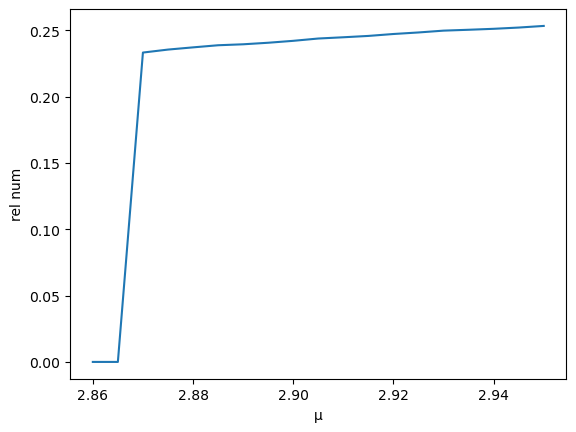

In [7]:
min_mu = 5;
for key in d.keys():
    a = (d[key].nonzero())[0]
    if len(a):
        act_min = mu_list[np.min(a)]
        if act_min < min_mu:
            min_mu = act_min
print(min_mu)


#relative number of reached cut points sorted by different distances mu
plt.plot(mu_list, add_elOverMu(d,const_rel))

#plt.xlabel('geodesic length')
plt.xlabel('μ')
plt.ylabel('rel num')

plt.show()

In [ ]:
pickle.dump(d,open("np_dict_maxcruv_100_7_finer.pkl","wb"))

In [5]:
d = pickle.load(open("np_dict_maxcruv_100_7.pkl","rb"))

#in "np_dict_maxcruv_100_7.pkl" ist exp zu max curvature planes (4-100;2-7;25;2.86-2.95step19) (const_rel = 13800)

#in "np_dict_maxcruv_100_7_finer.pkl" ist exp zu max curvature planes (4-100;2-7;25;2.865-2.88step31) (const_rel = )
#is open